In [1]:
import pandas as pd
import nltk
from nltk import SnowballStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/sofia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%%writefile Stemmer.py
import nltk
from collections import defaultdict
from nltk import SnowballStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
class Stemmer(): # naive class
    def __init__(self):
        self.stems = list()
        self.stemmed_freqs = defaultdict(list)
        self.tokens = list()

    def tokenize(self, document):
        '''
        tokenize document and remove (some of) non-spanish words
        '''
        if not isinstance(document, list):
            if isinstance(document, str):
                self.tokens = document.split(' ')
            else:
                raise TypeError('str or dict expected, {} found.'.format(type(document)))
        else:
            self.tokens = document
    
    def stemm(self, document):
        '''
        document stemming
        '''
        if len(self.tokens) == 0: #empty list
            self.tokenize(document)
        else:
            spanishstemmer = SnowballStemmer('spanish')
            self.stems = [spanishstemmer.stem(token) for token in self.tokens] 

Overwriting Stemmer.py


In [3]:
def remove_short_words(stringObj, wordLong = 4):
    '''
    remove words with lenght <= wordLong
    
    return: list
    '''
    listObj = stringObj.split(' ')
    words = list()
    words = [word for word in listObj if len(word)>wordLong]
    return words

In [4]:
def remove_less_frequent_words(myList, frequency=10):
    from collections import Counter
    words_freq = Counter(myList)
    result = list()
    words = [[elem[0]]*elem[1] for elem in words_freq.items() if elem[1] >= frequency]    
    for val in words:
        result.extend(val)
    return result  

In [5]:
originData = pd.read_csv("../data/interim/dataset_v2.csv")

In [6]:
originData.head()

,Unnamed: 0,manually_assigned_tag,url,content
0,0,supermarket,https://www.walmart.com.ar,nueva nueva correctamente puede cerrar lacteos...
1,0,supermarket,https://www.makro.com.ar/ofertas,logo entra cuenta quiero fornecedor sustentabi...
2,0,supermarket,https://www.alvearsupermercados.com.ar/ofertas/,alvearsupermercados logo blanco alvearsupermer...
3,0,supermarket,https://www.cotodigital3.com.ar/sitios/cdigi/b...,experiencia descuentos descuentos comparacione...
4,0,telephone,https://www.personal.com.ar/,micuenta destinos cuenta micuenta cuenta finan...


In [7]:
originData = originData.drop(columns=['Unnamed: 0'])

In [8]:
originData.columns

Index(['manually_assigned_tag', 'url', 'content'], dtype='object')

In [9]:
originData.head()

,manually_assigned_tag,url,content
0,supermarket,https://www.walmart.com.ar,nueva nueva correctamente puede cerrar lacteos...
1,supermarket,https://www.makro.com.ar/ofertas,logo entra cuenta quiero fornecedor sustentabi...
2,supermarket,https://www.alvearsupermercados.com.ar/ofertas/,alvearsupermercados logo blanco alvearsupermer...
3,supermarket,https://www.cotodigital3.com.ar/sitios/cdigi/b...,experiencia descuentos descuentos comparacione...
4,telephone,https://www.personal.com.ar/,micuenta destinos cuenta micuenta cuenta finan...


In [10]:
# Delete rows with empty 'content' field
originData.dropna(subset = ["content"], inplace=True)

In [11]:
originData['content'] = originData['content'].map(lambda x: remove_short_words(x))

In [12]:
# originData['content'] = originData['content'].map(lambda x: remove_less_frequent_words(x, 2))

In [13]:
myDF = originData.copy(deep=True)
myDF = myDF.drop(columns=['manually_assigned_tag'])

In [14]:
myDict = dict(zip(myDF.url, myDF.content)) # -> key: url, value:content (list)

# Word lenght analysis

In [15]:
all_values = list()
uniqueValues = list()
uniqueValuesLs = list(myDict.values())
for l in uniqueValuesLs:
    all_values.extend(l)
    uniqueValues.extend(list(set(l)))
uniqueValues = list(set(uniqueValues))

In [16]:
# all_values

In [17]:
# uniqueValues

In [18]:
wordLenDic = dict()
lens = list()
for word in uniqueValues:
    lens.append(len(word))
wordLenDic = {'words':uniqueValues, 'lenghts':lens}
wordLenDF = pd.DataFrame.from_dict(wordLenDic, orient='columns')

In [19]:
# wordLenDF

In [20]:
wordLenDF.head()

,words,lenghts
0,adjuntos,8
1,nuevobancodesantafe,19
2,escudo,6
3,licitaciones,12
4,supuestamente,13


In [21]:
wordLenDF.describe()

,lenghts
count,2161.000000
mean,8.946784
std,2.907595
min,5.000000
25%,7.000000
50%,9.000000
75%,10.000000
max,42.000000


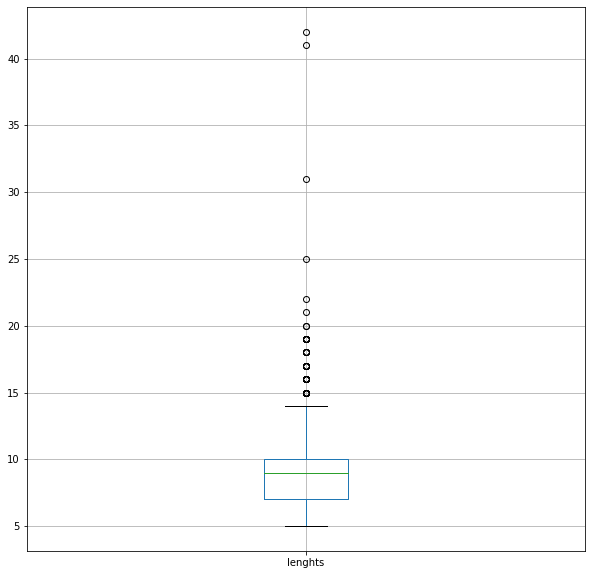

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
boxplot = wordLenDF.boxplot(column=['lenghts'])

In [60]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(wordLenDF[wordLenDF.lenghts ==16])

                 words  lenghts
16    directoalpaladar       16
210   editorialoctubre       16
224   especialdesayuno       16
494   confidencialidad       16
753   logoclasificados       16
1236  proveedoresclaro       16
1416  fundamentalistas       16
1421  desmaquilladores       16
1440  comercializacion       16
1574  myfunctioncadena       16
1741  cocacolaportugal       16
1774  diariodelviajero       16
1888  prestamosfebrero       16
1921  especificaciones       16


In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(wordLenDF[wordLenDF.lenghts ==5])

      words  lenghts
34    acoso        5
50    entry        5
107   canal        5
112   queda        5
121   casas        5
160   nueva        5
163   guide        5
189   video        5
194   unido        5
206   uelas        5
220   decor        5
225   puede        5
238   banco        5
240   elias        5
242   bueno        5
270   local        5
299   desea        5
306   resto        5
317   lados        5
324   larry        5
341   nacio        5
365   placa        5
387   acasi        5
413   cuido        5
425   juexz        5
431   lucas        5
435   todes        5
437   carro        5
444   quedo        5
460   clara        5
463   close        5
479   array        5
497   entra        5
498   peros        5
507   unico        5
533   lleno        5
535   yzmqu        5
554   cacao        5
555   rocio        5
629   cases        5
661   acero        5
665   cdesc        5
679   cobra        5
688   libro        5
705   cesar        5
714   edcio        5
768   elena  

In [25]:
from collections import defaultdict
wordFreqDic = defaultdict(int)
for word in all_values:
    wordFreqDic[word] += 1
sortedWordFreqDic = {k: v for k, v in sorted(wordFreqDic.items(), key=lambda item: item[1], reverse=True)}

In [26]:
sortedWordFreqDic

{'cordoba': 509,
 'deportes': 268,
 'precio': 265,
 'servicios': 232,
 'sociedad': 196,
 'productos': 165,
 'alvearsupermercados': 153,
 'despegar': 137,
 'buenos': 136,
 'especial': 133,
 'desayuno': 126,
 'nueva': 125,
 'mercadolibre': 124,
 'cuenta': 121,
 'claro': 119,
 'propiedades': 111,
 'cadena': 111,
 'nuevo': 105,
 'ciudad': 104,
 'suplementos': 104,
 'video': 102,
 'macro': 100,
 'beneficios': 99,
 'informacion': 99,
 'barcelona': 94,
 'barrio': 94,
 'videos': 92,
 'aeropuerto': 91,
 'ciudadanos': 90,
 'hombre': 85,
 'departamento': 83,
 'congelados': 79,
 'libre': 78,
 'electro': 77,
 'mexico': 76,
 'canales': 75,
 'internacional': 74,
 'clasificados': 73,
 'lanacion': 73,
 'propiedad': 71,
 'contenido': 70,
 'internacionales': 70,
 'carlos': 67,
 'personas': 66,
 'retenciones': 65,
 'report': 65,
 'deseos': 64,
 'puede': 61,
 'cocina': 57,
 'redaccion': 56,
 'cuentas': 56,
 'precios': 54,
 'espacio': 54,
 'rosario': 54,
 'soluciones': 53,
 'contacto': 52,
 'posible': 52,
 

In [27]:
words_= list(sortedWordFreqDic.keys())
# print(words_)
freqs_ = list(sortedWordFreqDic.values())
sortedWordFreqDic_toDf = {'words_': words_, 'freqs_':freqs_}
wordFreqDF = pd.DataFrame.from_dict(sortedWordFreqDic_toDf, orient='columns')

In [28]:
wordFreqDF.describe()

,freqs_
count,2161.000000
mean,7.894956
std,21.288181
min,1.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,509.000000


In [29]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(wordFreqDF[wordFreqDF.freqs_ > 40])

                 words_  freqs_
0               cordoba     509
1              deportes     268
2                precio     265
3             servicios     232
4              sociedad     196
5             productos     165
6   alvearsupermercados     153
7              despegar     137
8                buenos     136
9              especial     133
10             desayuno     126
11                nueva     125
12         mercadolibre     124
13               cuenta     121
14                claro     119
15          propiedades     111
16               cadena     111
17                nuevo     105
18               ciudad     104
19          suplementos     104
20                video     102
21                macro     100
22           beneficios      99
23          informacion      99
24            barcelona      94
25               barrio      94
26               videos      92
27           aeropuerto      91
28           ciudadanos      90
29               hombre      85
30      

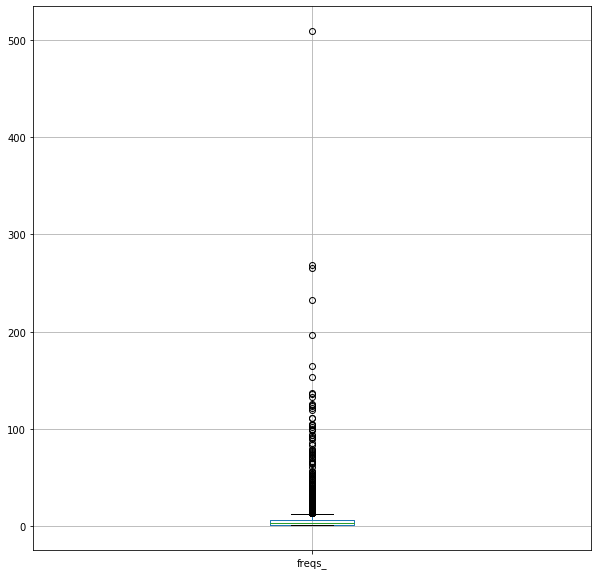

In [30]:
plt.figure(figsize = (10,10))
boxplot = wordFreqDF.boxplot(column=['freqs_'])

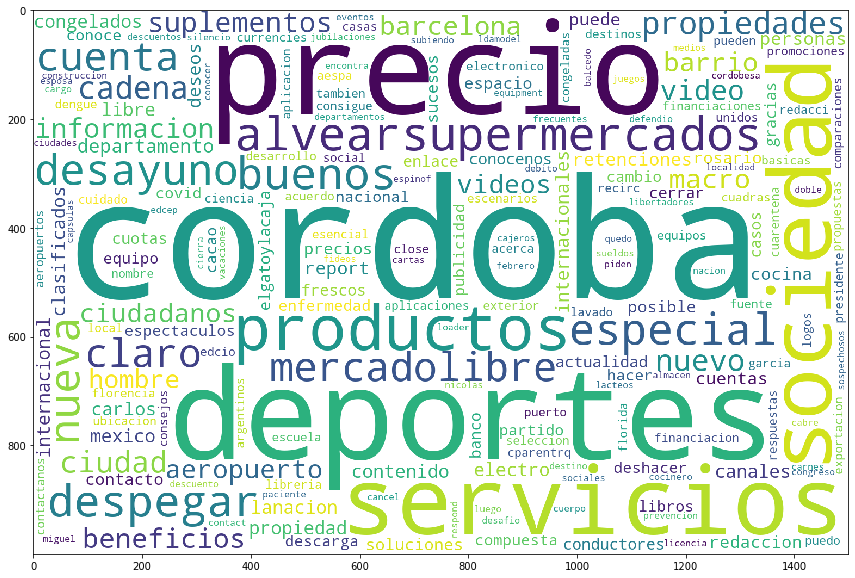

In [31]:
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize = (30,10))
wc = WordCloud(background_color='white', width=1500, height=1000).generate_from_frequencies(sortedWordFreqDic)
plt.imshow(wc)

In [64]:
ignoreWords = ['servicios', 'sociedad', 'cordoba', 'alvearsupermercados', 'elgatoylacaja', 'claro', 'mercadolibre', 'deportes', 'despegar', 'macro', 'lanacion']

# _________________________________________________________________________________________________


# Sparse document-term matrix

In [65]:
# Update dataframe to filter out long words
originData['content'] = originData['content'].map(lambda x: [w for w in x if ((len(w)<15 or len(w)>5) and (w not in ignoreWords))])

In [66]:
originData.head()

,manually_assigned_tag,url,content
0,supermarket,https://www.walmart.com.ar,"[nueva, nueva, correctamente, puede, cerrar, l..."
1,supermarket,https://www.makro.com.ar/ofertas,"[entra, cuenta, quiero, fornecedor, sustentabi..."
2,supermarket,https://www.alvearsupermercados.com.ar/ofertas/,"[blanco, blanco, cuenta, frecuentes, frecuente..."
3,supermarket,https://www.cotodigital3.com.ar/sitios/cdigi/b...,"[experiencia, descuentos, descuentos, comparac..."
4,telephone,https://www.personal.com.ar/,"[micuenta, destinos, cuenta, micuenta, cuenta,..."


In [67]:
myDict = dict(zip(originData.url, originData.content)) # -> key: url, value:content (list)

In [68]:
n_nonzero = 0
vocab = set()
for docterms in myDict.values():
    unique_terms = set(docterms)    # all unique terms of this doc
    vocab |= unique_terms           # set union: add unique terms of this doc
    n_nonzero += len(unique_terms)  # add count of unique terms in this doc

# make a list of document names
# the order will be the same as in the dict
docnames = list(myDict.keys())
docnamesNmb = list(range(0, len(docnames)))

In [69]:
import numpy as np
docnames = np.array(docnames)
vocab = np.array(list(vocab))

In [70]:
docnames.size

72

In [71]:
vocab.size

2149

In [72]:
vocab_sorter = np.argsort(vocab)    # indices that sort "vocab"

In [73]:
# The dimensions of the matrix will be len(docnames) x len(vocab)
ndocs = len(docnames)
nvocab = len(vocab)

In [74]:
data = np.empty(n_nonzero, dtype=np.intc)     # all non-zero term frequencies at data[k]
rows = np.empty(n_nonzero, dtype=np.intc)     # row index for kth data item (kth term freq.)
cols = np.empty(n_nonzero, dtype=np.intc)     # column index for kth data item (kth term freq.)

In [75]:
ind = 0     # current index in the sparse matrix data
# go through all documents with their terms
for docname, terms in myDict.items():
    # find indices into  such that, if the corresponding elements in  were
    # inserted before the indices, the order of  would be preserved
    # -> array of indices of  in 
    term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]

    # count the unique terms of the document and get their vocabulary indices
    uniq_indices, counts = np.unique(term_indices, return_counts=True)
    n_vals = len(uniq_indices)  # = number of unique terms
    ind_end = ind + n_vals  #  to  is the slice that we will fill with data

    data[ind:ind_end] = counts                  # save the counts (term frequencies)
    cols[ind:ind_end] = uniq_indices            # save the column index: index in 
    doc_idx = np.where(docnames == docname)     # get the document index for the document name
    rows[ind:ind_end] = np.repeat(doc_idx, n_vals)  # save it as repeated value

    ind = ind_end  # resume with next document -> add data to the end

In [76]:
from scipy.sparse import coo_matrix
dtm = coo_matrix((data, (rows, cols)), shape=(ndocs, nvocab), dtype=np.intc)
maxElement = np.amax(dtm.toarray())
minElement = np.amin(dtm.toarray())
print(maxElement)
print(minElement)
print((maxElement - minElement)/2)

111
0
55.5


In [80]:
import lda
topics = 10
model = lda.LDA(n_topics=topics, n_iter=1500, random_state=15)
model.fit(dtm)
topic_word = model.topic_word_
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

INFO:lda:n_documents: 72
INFO:lda:vocab_size: 2149
INFO:lda:n_words: 15054
INFO:lda:n_topics: 10
INFO:lda:n_iter: 1500
/home/sofia/.local/share/virtualenvs/topic_modeling-Gm6ev8G1/lib/python3.6/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:lda:<0> log likelihood: -162613
INFO:lda:<10> log likelihood: -103356
INFO:lda:<20> log likelihood: -99106
INFO:lda:<30> log likelihood: -97759
INFO:lda:<40> log likelihood: -96980
INFO:lda:<50> log likelihood: -96243
INFO:lda:<60> log likelihood: -95590
INFO:lda:<70> log likelihood: -95259
INFO:lda:<80> log likelihood: -95054
INFO:lda:<90> log likelihood: -94858
INFO:lda:<100> log likelihood: -94737
INFO:lda:<110> log likelihood: -94657
INFO:lda:<120> log likelihood: -94561
INFO:lda:<130> log likelihood: -94458
INFO:lda:<140> log

Topic 0: suplementos carlos libros social fuente logos florida presidente videos garcia
Topic 1: propiedades buenos aeropuerto barcelona barrio internacional partido ciudad destinos nueva
Topic 2: desayuno especial precio report compuesta cacao libreria doble libre fideos
Topic 3: deseos departamento close cuadras recirc ldamodel contact cancel respond barrio
Topic 4: ciudadanos video clasificados videos redaccion sucesos actualidad internacionales espacio publicidad
Topic 5: cadena conductores nueva nuevo hacer mexico retenciones enfermedad internacional ciudad
Topic 6: propiedad informacion puede contacto hombre precio acerca pueden construccion equipo
Topic 7: productos beneficios cuenta canales cuentas personas conocenos soluciones contenido informacion
Topic 8: precio electro congelados frescos libre cparentrq cocina aespa cuidado comparaciones
Topic 9: gracias deshacer nuevo aplicaciones currencies consigue cerrar respuestas precio seleccion



## **Topic 1**: ~ Agencia de viajes
## **Topic 2, 8**: ~ Supermercado
## **Topic 4, 5**: ~ Noticias, diario
## **Topic** ...